In [31]:
import sys
import os
import numpy as np
import torch

cwd = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(cwd)))

In [63]:
from src.utils import load_model
model, _ = load_model('../../outputs/tsp_10/rollout_20230720T020325')
model.eval()  # Put in evaluation mode to not track gradients

np.random.seed(1234)
xy = np.random.rand(10, 2)

def make_oracle(model, xy, temperature=1.0):
    
    num_nodes = len(xy)
    
    xyt = torch.tensor(xy).float()[None]  # Add batch dimension
    
    with torch.no_grad():  # Inference only
        embeddings = model.encoder(model._init_embed(xyt))

        # Compute keys, values for the glimpse and keys for the logits once as they can be reused in every step
        fixed = model._precompute(embeddings)
    
    def oracle(tour):
        with torch.no_grad():  # Inference only
            # Input tour with 0 based indices
            # Output vector with probabilities for locations not in tour
            tour = torch.tensor(tour).long()
            if len(tour) == 0:
                step_context = model.W_placeholder
            else:
                step_context = torch.cat((embeddings[0, tour[0]], embeddings[0, tour[-1]]), -1)

            # Compute query = context node embedding, add batch and step dimensions (both 1)
            query = fixed.context_node_projected + model.decoder.project_step_context(step_context[None, None, :])

            # Create the mask and convert to bool depending on PyTorch version
            mask = torch.zeros(num_nodes, dtype=torch.uint8) > 0
            mask[tour] = 1
            mask = mask[None, None, :]  # Add batch and step dimension

            log_p, _ = model.decoder._get_attention_glimpse(query, fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key, mask)
            p = torch.softmax(log_p / temperature, -1)[0, 0]
            assert (p[tour] == 0).all()
            assert (p.sum() - 1).abs() < 1e-5
            #assert np.allclose(p.sum().item(), 1)
        return p.numpy()
    
    return oracle, xyt, embeddings
        


oracle, input, embeddings = make_oracle(model, xy)

sample = False
tour = []
tour_p = []
while(len(tour) < len(xy)):
    p = oracle(tour)
    
    if sample:
        # Advertising the Gumbel-Max trick
        g = -np.log(-np.log(np.random.rand(*p.shape)))
        i = np.argmax(np.log(p) + g)
        # i = np.random.multinomial(1, p)
    else:
        # Greedy
        i = np.argmax(p)
    tour.append(i)
    tour_p.append(p)
    
print(tour)

  [*] Loading model from ../../outputs/tsp_10/rollout_20230720T020325/epoch-39.pt
[2, 8, 5, 7, 0, 3, 1, 6, 9, 4]


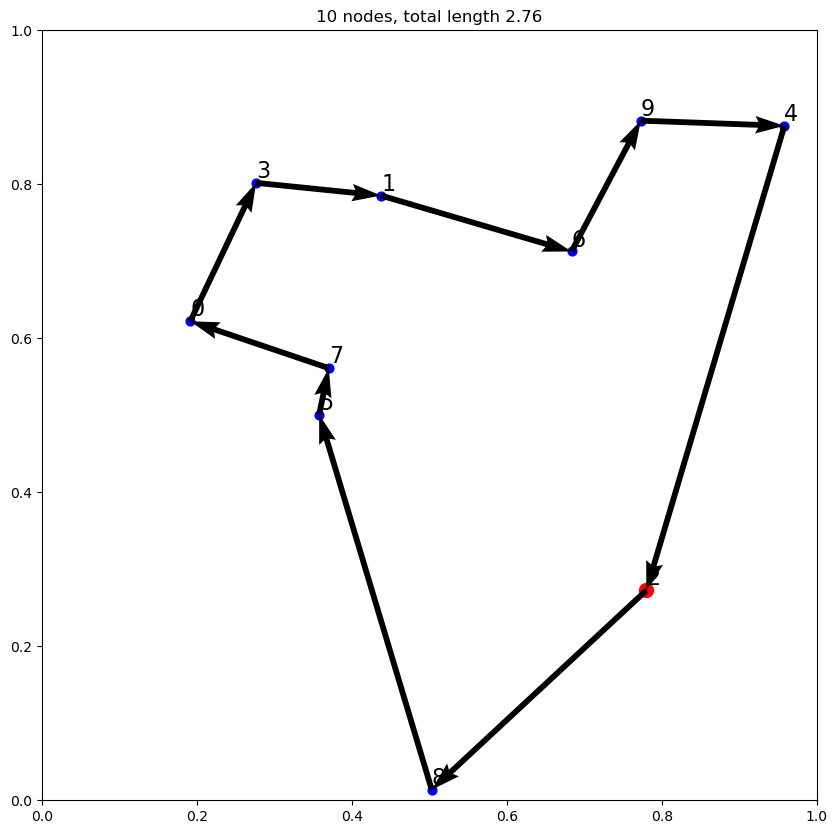

In [64]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1):
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    xs, ys = xy[tour].transpose()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes with node index
    for i, (x, y) in enumerate(zip(xs, ys)):
        ax1.scatter(x, y, s=40, color='blue')
        ax1.annotate(str(tour[i]), (x, y), fontsize=16, ha='left', va='bottom')

    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{} nodes, total length {:.2f}'.format(len(tour), lengths[-1]))
    
fig, ax = plt.subplots(figsize=(10, 10))
plot_tsp(xy, tour, ax)


MovieWriter imagemagick unavailable; using Pillow instead.



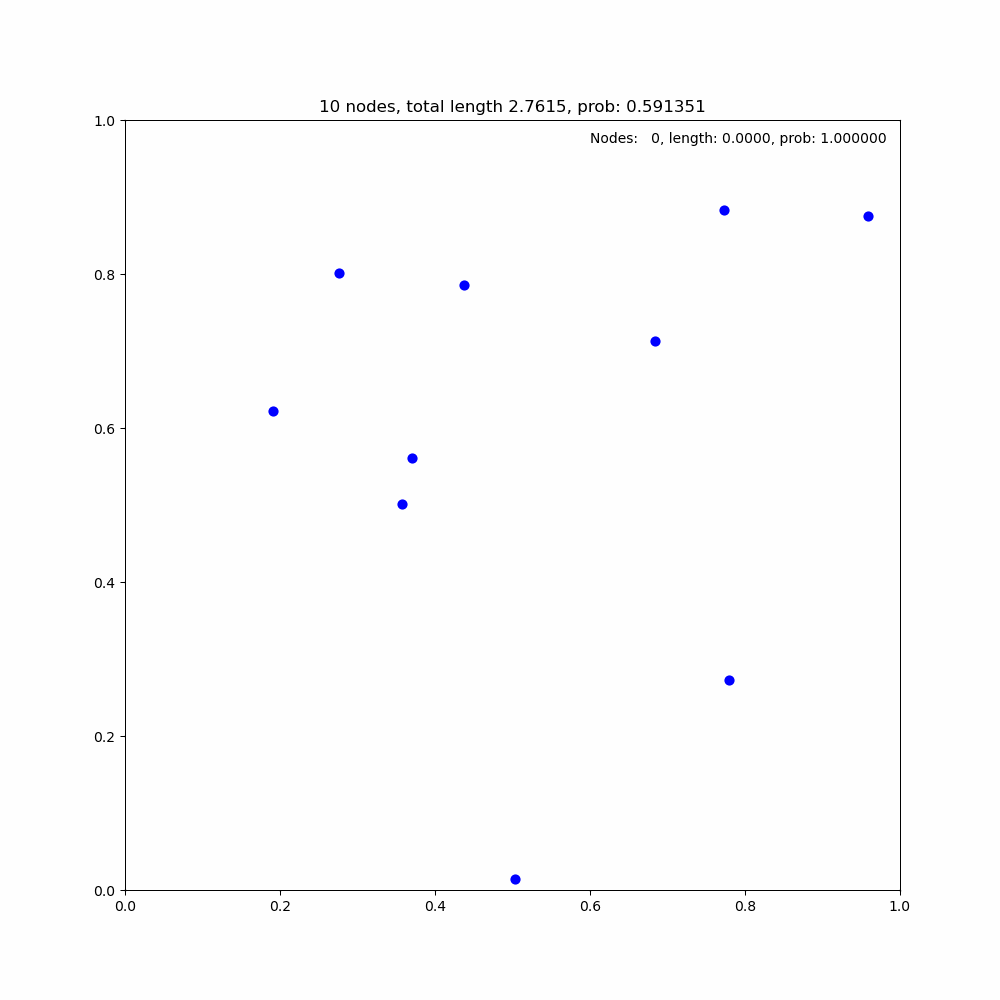

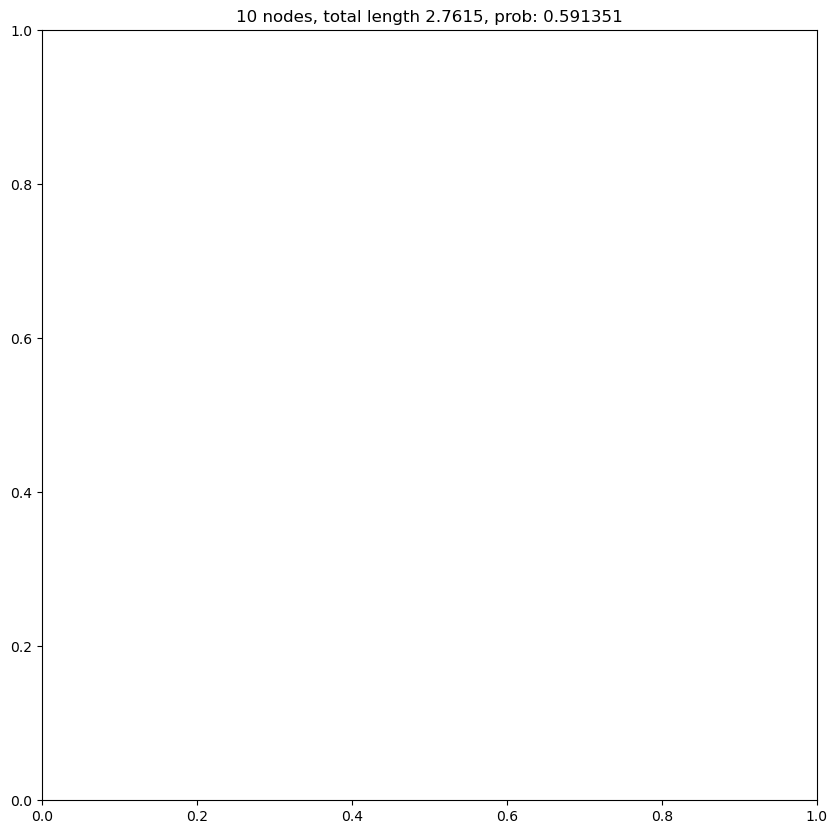

In [65]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython.display import HTML
import base64

from celluloid import Camera  # pip install celluloid

def format_prob(prob):
    return ('{:.6f}' if prob > 1e-5 else '{:.2E}').format(prob)

def plot_tsp_ani(xy, tour, tour_p=None, max_steps=1000):
    n = len(tour)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    camera = Camera(fig)

    total_length = 0
    cum_log_prob = 0
    for i in range(n + 1):
        for plot_probs in [False] if tour_p is None or i >= n else [False, True]:
            # Title
            title = 'Nodes: {:3d}, length: {:.4f}, prob: {}'.format(
                i, lengths[i - 2] if i > 1 else 0., format_prob(np.exp(cum_log_prob))
            )
            ax1.text(0.6, 0.97, title, transform=ax.transAxes)

            # First print current node and next candidates
            ax1.scatter(xs, ys, s=40, color='blue')

            if i > 0:
                ax1.scatter([xs[i - 1]], [ys[i - 1]], s=100, color='red')
            if i > 1:
                qv = ax1.quiver(
                    xs[:i-1],
                    ys[:i-1],
                    dx[:i-1],
                    dy[:i-1],
                    scale_units='xy',
                    angles='xy',
                    scale=1,
                )
            if plot_probs:
                prob_rects = [Rectangle((x, y), 0.01, 0.1 * p) for (x, y), p in zip(xy, tour_p[i]) if p > 0.01]
                pc = PatchCollection(prob_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
                ax1.add_collection(pc)
            camera.snap()
        if i < n and tour_p is not None:
            # Add cumulative_probability
            cum_log_prob += np.log(tour_p[i][tour[i]])
        if i > max_steps:
            break

    # Plot final tour
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    if tour_p is not None:
        # Note this does not use stable logsumexp trick
        cum_log_prob = format_prob(np.exp(sum([np.log(p[node]) for node, p in zip(tour, tour_p)])))
    else:
        cum_log_prob = '?'
    ax1.set_title('{} nodes, total length {:.4f}, prob: {}'.format(len(tour), lengths[-1], cum_log_prob))
    
    camera.snap()
    
    return camera 

    
animation = plot_tsp_ani(xy, tour, tour_p).animate(interval=500)
animation.save('../images/tsp/tsp.gif', writer='imagemagick', fps=2)  # requires imagemagick
# compress by running 'convert tsp.gif -strip -coalesce -layers Optimize tsp.gif'
# HTML(animation.to_html5_video())  # requires ffmpeg
b64 = base64.b64encode(open('../images/tsp/tsp.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [66]:
import seaborn as sns
# Function to set the color of labels
def set_label_colors(labels, colors):
    for label, color in zip(labels, colors):
        label.set_color(color)

def fix_naming(name):
    if name.split("_")[0] == "input":
        return "Original Input Nodes"
    return "Encoded Node Embeddings"

def plot_encoder_data(figures, ordered_nodes, node_colors=None, title="Distance Matrix of the TSP"):
    fig, axs = plt.subplots(1, len(figures), figsize=(20, 10))
    fig.suptitle(title, fontsize=18)

    # Create the heatmaps
    for index, (name, figure) in enumerate(figures.items()):
        ax = axs[index]
        ax.set_title(fix_naming(name), fontsize=16)

        # Create heatmap using seaborn
        cmap = plt.get_cmap('coolwarm')
        sns.heatmap(figure, cmap=cmap, annot=True, fmt=".2f", linewidths=.05, ax=ax,
                    xticklabels=ordered_nodes, yticklabels=ordered_nodes, cbar=False)

        # Set the xticklabels and yticklabels
        xticklabels = ax.get_xticklabels()
        yticklabels = ax.get_yticklabels()

    if node_colors is not None:
        set_label_colors(xticklabels, node_colors)
        set_label_colors(yticklabels, node_colors)

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Add colorbar for reference
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar
    fig.colorbar(ax.get_children()[0], cax=cbar_ax)
    

    plt.show()
    plt.close(fig)


def plot_attention_weights(model):

    for layer_idx in range(model.n_encode_layers):
        attention_layer = model.encoder.layers[layer_idx][0].module
        # First instance of the batch
        att = attention_layer.get_attention_weights()[:, 0, :, :].detach().cpu().numpy()

        # Plot the attention weights
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f"Layer {layer_idx + 1} - Attention Weights", fontsize=18)

        for head in range(attention_layer.num_heads):
            ax = axs[head // 4, head % 4]
            # Use seaborn heatmap for the plot
            cmap = plt.get_cmap('coolwarm_r')
            sns.heatmap(att[head], annot=True, fmt=".2f", linewidths=.05, cmap=cmap, ax=ax, cbar=False)

            # Set axis labels and title
            ax.set_xlabel("To Node", fontsize=12)
            ax.set_ylabel("From Node", fontsize=12)
            ax.set_title(f"Attention Head {head + 1}", fontsize=12)

        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.3)

        # Add colorbar for reference
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar

        fig.colorbar(ax.get_children()[0], cax=cbar_ax)
        cbar_ax.set_ylabel("Attention Weight", fontsize=16)

        # Convert the figure to a numpy array
        plt.show()


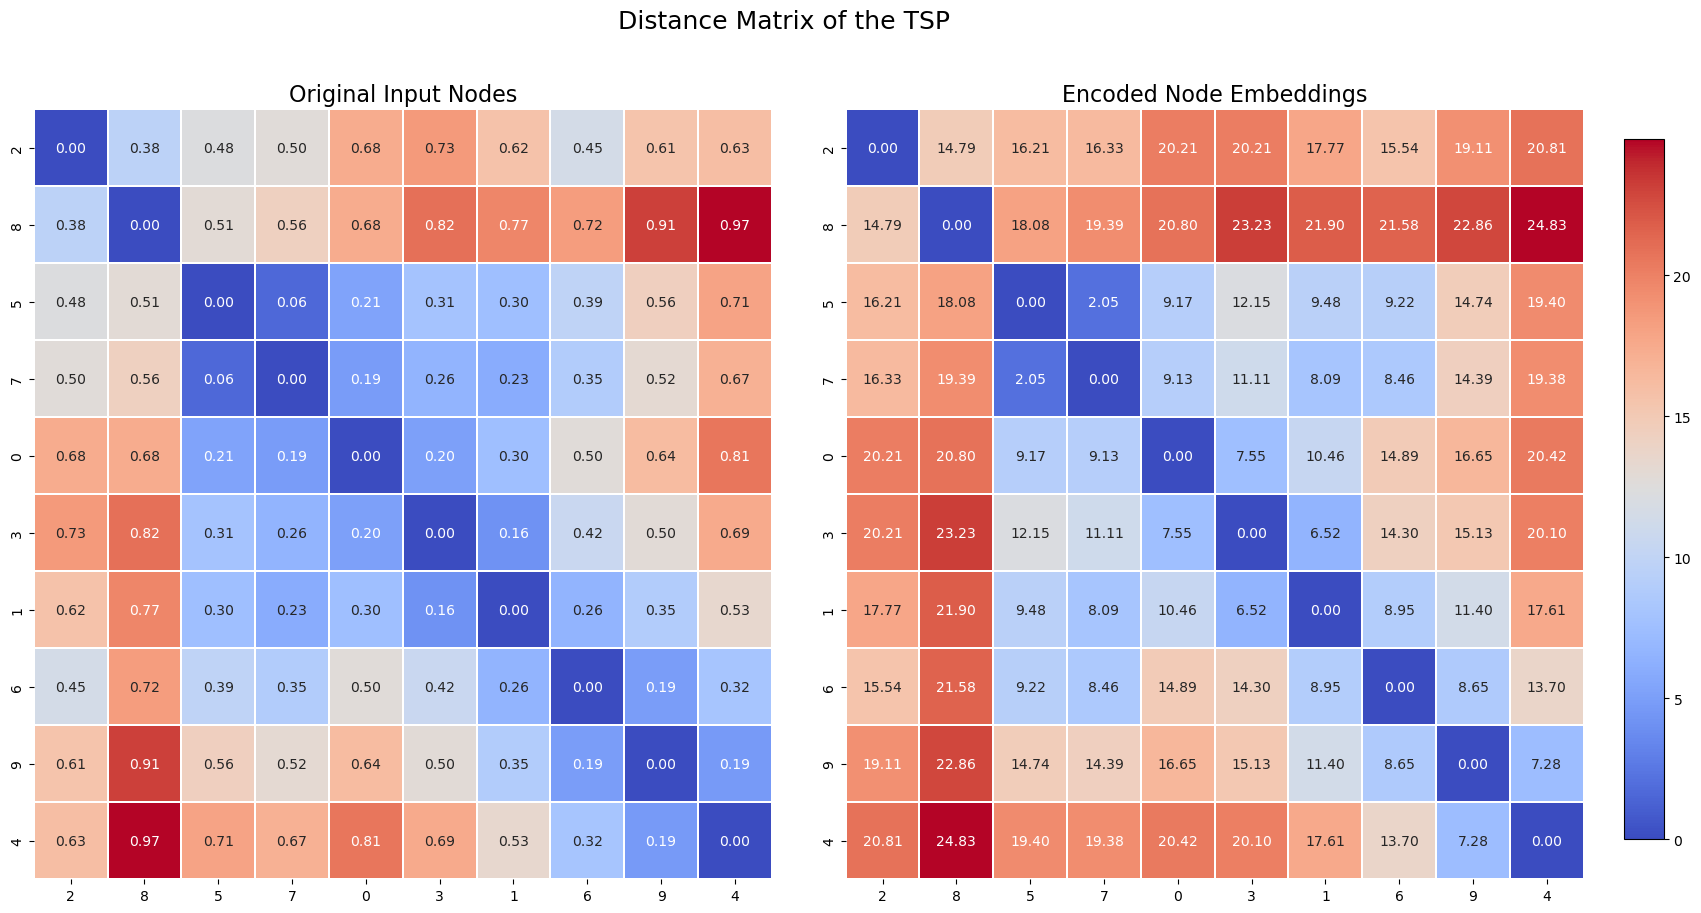

In [67]:
model_ = model

encoder_distance = {
    "input_distance": (
        input[0, :, None, :]-
        input[0, None, :, :]
    ).norm(p=2, dim=-1),
    "embedding_distance": (
        embeddings[0, :, None, :]
        - embeddings[0, None, :, :]
    ).norm(p=2, dim=-1),
}

ordered_figures = {k: v[tour][:, tour] for k, v in encoder_distance.items()}
plot_encoder_data(ordered_figures, tour)
# plot_attention_weights(model_)

In [68]:
xs, ys = xy[tour].transpose()
xs, ys = xy[tour].transpose()
dx = np.roll(xs, -1) - xs
dy = np.roll(ys, -1) - ys

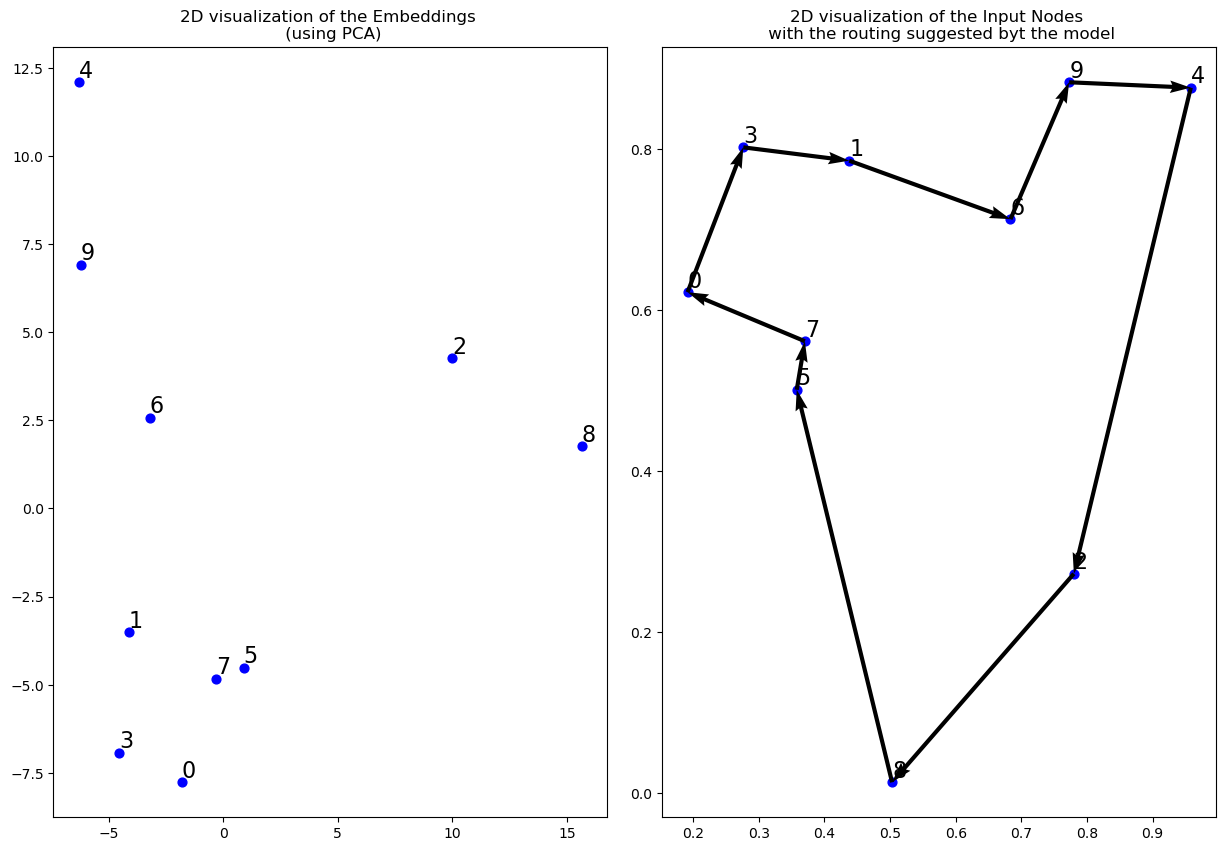

In [69]:
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# Use t-SNE to reduce dimensionality to 2D for visualization
# proj = TSNE(n_components=2, perplexity=embeddings[0].shape[0] - 1)
proj = PCA(n_components=2)
embeddings_2d = proj.fit_transform(embeddings[0])

# Plot the 2D embeddings
fig, ax = plt.subplots(1, 2, figsize=(15,10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.title("Traveling Salesman Problem")

# Scatter nodes with node index
for i, (x, y) in enumerate(zip(embeddings_2d[:, 0], embeddings_2d[:, 1])):
    ax[0].scatter(x, y, s=40, color='blue')
    ax[0].annotate(str(i), (x, y), fontsize=16, ha='left', va='bottom')
    ax[0].set_title("2D visualization of the Embeddings \n (using PCA)")

# plt.scatter(input[0][:, 0], input[0][:, 1])
for i, (x, y) in enumerate(zip(xy[:, 0], xy[:, 1])):
    ax[1].scatter(x, y, s=40, color='blue')
    ax[1].annotate(str(i), (x, y), fontsize=16, ha='left', va='bottom')
    # Arcs
    ax[1].set_title("2D visualization of the Input Nodes \n with the routing suggested byt the model")

ax[1].quiver(
    xs, ys, 
    dx, dy,
    scale_units='xy',
    angles='xy',
    scale=1
)
plt.show()

In [70]:
tour

[2, 8, 5, 7, 0, 3, 1, 6, 9, 4]

In [71]:
embeddings_2d.shape

(10, 2)

In [72]:
embeddings.shape

torch.Size([1, 10, 128])

In [73]:
input.shape

torch.Size([1, 10, 2])

In [74]:
xy

array([[0.19151945, 0.62210877],
       [0.43772774, 0.78535858],
       [0.77997581, 0.27259261],
       [0.27646426, 0.80187218],
       [0.95813935, 0.87593263],
       [0.35781727, 0.50099513],
       [0.68346294, 0.71270203],
       [0.37025075, 0.56119619],
       [0.50308317, 0.01376845],
       [0.77282662, 0.88264119]])

In [75]:
input

tensor([[[0.1915, 0.6221],
         [0.4377, 0.7854],
         [0.7800, 0.2726],
         [0.2765, 0.8019],
         [0.9581, 0.8759],
         [0.3578, 0.5010],
         [0.6835, 0.7127],
         [0.3703, 0.5612],
         [0.5031, 0.0138],
         [0.7728, 0.8826]]])

In [76]:
embeddings_2d

array([[-1.81914201, -7.76866221],
       [-4.11914678, -3.5132963 ],
       [ 9.98769545,  4.25370967],
       [-4.53841628, -6.93811058],
       [-6.31372854, 12.08545538],
       [ 0.88819883, -4.51556691],
       [-3.21338134,  2.56351228],
       [-0.30399638, -4.83285585],
       [15.6507801 ,  1.75576792],
       [-6.21886305,  6.91004661]])

In [91]:

import torch 
distances_between_inputs = torch.tensor(input[:, None, :] - input[:, :, None]).clone().detach().norm(p=2, dim=-1).reshape(-1)
distances_between_outputs = torch.tensor(embeddings_2d[None, :] - embeddings_2d[:, None]).clone().detach().norm(p=2, dim=-1).reshape(-1)

/var/folders/gl/_6q874612pv_5g7n_b2_wbb40000gn/T/ipykernel_63267/257216318.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distances_between_inputs = torch.tensor(input[:, None, :] - input[:, :, None]).clone().detach().norm(p=2, dim=-1).reshape(-1)


In [92]:
distances_between_inputs.shape

torch.Size([100])

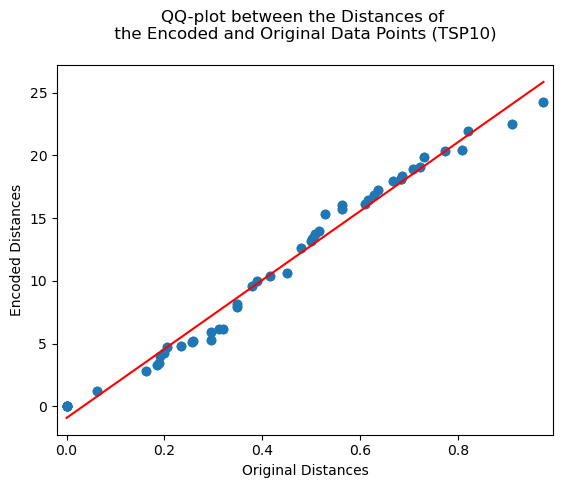

In [94]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

# Assume you have dataset1 and dataset2

pp_x = sm.ProbPlot(distances_between_inputs)
pp_y = sm.ProbPlot(distances_between_outputs)

# Create the QQ plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Generate QQ plot
plt.title("QQ-plot between the Distances of \n the Encoded and Original Data Points (TSP10) \n")
qq = sm.qqplot_2samples(pp_x, pp_y, line='r', ax=ax, xlabel="Original Distances", ylabel="Encoded Distances")

# Show the plot
plt.show()


In [95]:
from scipy.interpolate import interp1d

# Get the actual points on the QQ plot
actual_points = qq.axes[0].lines[0].get_xydata()

# Get the regression line
reg_line = qq.axes[0].lines[1].get_xydata()

f = interp1d(reg_line[:, 0], reg_line[:, 1], kind='linear')
regression_y = f(actual_points[:, 0])

# Calculate the differences 
difference = actual_points - np.column_stack((reg_line[:, 0], regression_y))
difference2 = actual_points - reg_line

distance = torch.tensor(difference).norm(p=2, dim=-1)
distance2 = torch.tensor(difference2).norm(p=2, dim=-1)

# Print differences?
print(distance.mean(), distance.median())
print(distance2.mean(), distance2.median())

tensor(0.7214, dtype=torch.float64) tensor(0.6859, dtype=torch.float64)
tensor(0.7214, dtype=torch.float64) tensor(0.6859, dtype=torch.float64)
